[View in Colaboratory](https://colab.research.google.com/github/J-Fo-S/ml-summer/blob/master/TF_Hub_generative_image_module_mod00.ipynb)

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub generative image model

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>


This Colab demonstrates use of a TF-Hub module based on a generative adversarial network (GAN). The module maps from N-dimensional vectors, called latent space, to RGB images.

see: https://www.tensorflow.org/hub/modules/google/progan-128/1

https://www.tensorflow.org/hub/

https://www.tensorflow.org/hub/common_signatures/images

https://www.tensorflow.org/api_docs/python/hub/Module

https://damienpontifex.com/2018/04/21/image-classification-using-tensorflow-estimators-and-tensorflow-hub-for-transfer-learning/

https://arxiv.org/abs/1710.10196

try combining with: http://cvl-demos.cs.nott.ac.uk/vrn/

Two examples are provided:
* **Mapping** from latent space to images, and
* Given a target image, **using gradient descent to find** a latent vector that generates an image similar to the target image.

## Optional prerequisites

* Familiarity with [low level Tensorflow concepts](https://www.tensorflow.org/programmers_guide/low_level_intro).
* [Generative Adversarial Network](https://en.wikipedia.org/wiki/Generative_adversarial_network) on Wikipedia.
* Paper on Progressive GANs: [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196).

In [9]:
# Install the latest Tensorflow version.
!pip -q install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip -q install tensorflow-hub
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Latent space interpolation

### Random vectors

Latent space interpolation between two randomly initialized vectors. We will use a TF-Hub module [progan-128](https://tfhub.dev/google/progan-128/1) that contains a pre-trained Progressive GAN.

In [0]:
#@title Imports and function definitions

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512

graph = tf.Graph()
config = tf.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.allow_growth = True
tf.logging.set_verbosity(tf.logging.ERROR)

# Simple way to display an image.
def display_image(image):
  plt.figure(figsize=(5,5))
  plt.axis("off")
  plt.imshow(image)
  plt.show()
    
def plot_images(images, ncols=1, nrows=1, size=5, captions=None):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5, nrows*5))
    for i, _ in enumerate(images):
        axes.ravel()[i].set_axis_off()
        axes.ravel()[i].imshow(images[i])
        if captions is not None:
            axes.ravel()[i].set_title(title)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

def get_module_pd_image(pd):
  with graph.as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.constant(pd, dtype=tf.float32, shape=[1, latent_dim])
    images = module(vector)

    with tf.Session(graph=graph, config=config) as session:
      session.run(tf.global_variables_initializer())
      print(vector)
      image_out = session.run(images)[0]
  return image_out

def get_module_seed_image(seed):
  with graph.as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.random_normal([1, latent_dim], seed=seed)
    images = module(vector)

    with tf.Session(graph=graph, config=config) as session:
      session.run(tf.global_variables_initializer())
      print(vector)
      image_out = session.run(images)[0]
  return image_out

# display 20 same visualizations from latent space - just to show feed_dict next run
def get_multi_mod_images(imgs):
  images = []
  with graph.as_default():
      module = hub.Module("https://tfhub.dev/google/progan-128/1")

      with tf.Session(graph=graph, config=config) as session:
        vector = tf.random_normal([1, latent_dim], seed=np.random.randint(100))
        session.run(tf.global_variables_initializer())
        for _ in range(imgs):
          image = module(vector)
          im_out = session.run(image)
          images.append(im_out[0])
  return images

# display 20 random visualizations from latent space
# try different mean and dev for random vals
def get_rand_mod_images(imgs):
  images = []
  with graph.as_default():
      module = hub.Module("https://tfhub.dev/google/progan-128/1")

      with tf.Session(graph=graph, config=config) as session:
        vec_holder = tf.placeholder(name='rand', shape=[1, latent_dim], dtype=tf.float32)
        session.run(tf.global_variables_initializer())
        for _ in range(imgs):
          image = module(vec_holder)
          im_out = session.run(image,
            feed_dict={ vec_holder: np.random.normal(loc =0, scale =0.5, size=(1, latent_dim)) })
          images.append(im_out[0])
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[uploaded.keys()[0]])
  return transform.resize(image, [128, 128])

def img_arr_in(img, anti_aliasing=True):
  img = np.expand_dims(img.ravel(), axis=0)
  return transform.resize(img, (1,512))

# Given a set of images, show an animation.
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))

# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

def interpolate_between_vectors():
  with graph.as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    # Change the seed to get different random vectors.
    v1 = tf.random_normal([latent_dim], seed=3)
    v2 = tf.random_normal([latent_dim], seed=1)
    
    # Creates a tensor with 50 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Uses module to generate images from the latent space.
    interpolated_images = module(vectors)

    with tf.Session(graph=graph, config=config) as session:
      session.run(tf.global_variables_initializer())
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)
 
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []
  with graph.as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random_normal([1, latent_dim], seed=None)

    vector = tf.get_variable("vector", initializer=initial_vector)
    image = module(vector)

    target_image_difference = tf.reduce_sum(
        tf.losses.absolute_difference(image[0], target_image[:,:,:3]))

    # The latent vectors were sampled from a normal distribution. We can get
    # more realistic images if we regularize the length of the latent vector to 
    # the average length of vector from this distribution.
    regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
    
    loss = target_image_difference + regularizer
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
    train = optimizer.minimize(loss)

    with tf.Session(graph=graph, config=config) as session:
      session.run(tf.global_variables_initializer())
      for i in range(num_optimization_steps):
        _, loss_out, im_out = session.run([train, loss, image])
        images.append(im_out[0])
        losses.append(loss_out)
        if i %10==0:
          print(loss_out)
    return images, losses


## Finding closest vector in latent space
Fix a target image. As an example use an image generated from the module or upload your own.

In [19]:
with graph.as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    print(module.get_input_info_dict())

{'latent_vector': <hub.ParsedTensorInfo shape=(?, 512) dtype=float32 is_sparse=False>}


Tensor("random_normal:0", shape=(1, 512), dtype=float32)


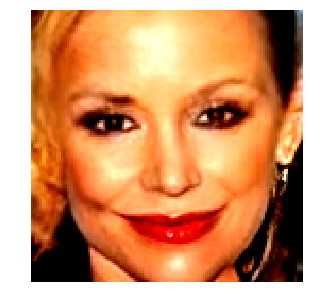

In [20]:
target_image = get_module_seed_image(400)
display_image(target_image)

Tensor("random_normal_1:0", shape=(1, 512), dtype=float32)


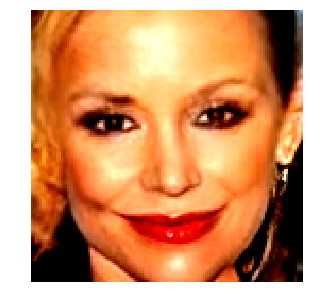

Tensor("random_normal_2:0", shape=(1, 512), dtype=float32)


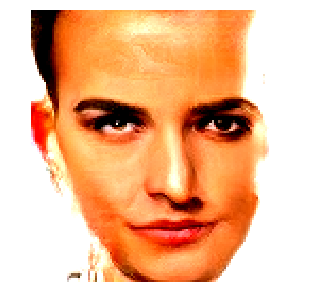

In [21]:
target_image1 = get_module_seed_image(400)
display_image(target_image1)
target_image2 = get_module_seed_image(200)
display_image(target_image2)

In [47]:
image_return1 = img_arr_in(target_image1)

(128, 128, 3)
(1, 49152)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


TO-DO: Write function combining a variety of meaningful cross-vector arithmetic (e.g. smile/frown, man/woman, long hair/short hair, etc.)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Tensor("Const_20:0", shape=(1, 512), dtype=float32)


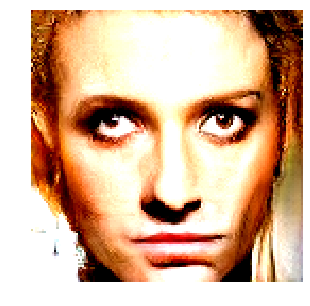

Tensor("Const_21:0", shape=(1, 512), dtype=float32)


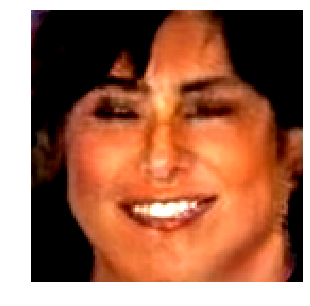

Tensor("Const_22:0", shape=(1, 512), dtype=float32)


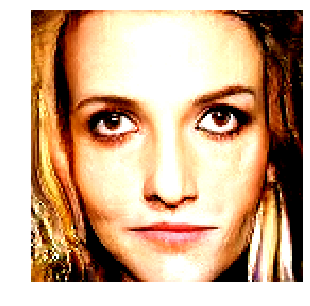

Tensor("Const_23:0", shape=(1, 512), dtype=float32)


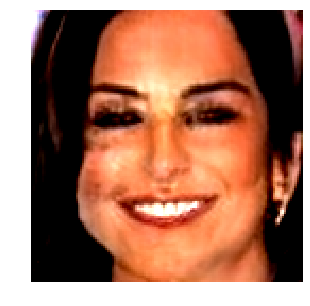

Tensor("Const_24:0", shape=(1, 512), dtype=float32)


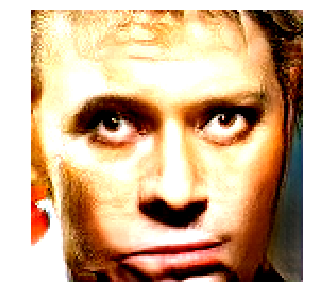

Tensor("Const_25:0", shape=(1, 512), dtype=float32)


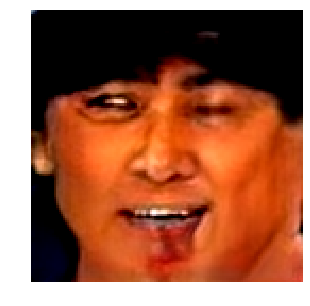

Tensor("Const_26:0", shape=(1, 512), dtype=float32)


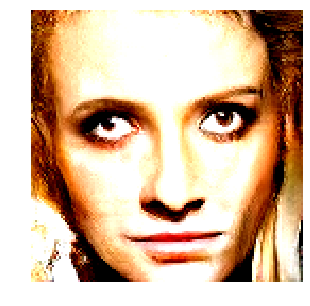

Tensor("Const_27:0", shape=(1, 512), dtype=float32)


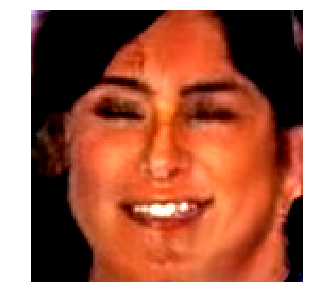

Tensor("Const_28:0", shape=(1, 512), dtype=float32)


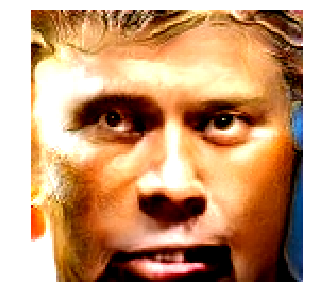

Tensor("Const_29:0", shape=(1, 512), dtype=float32)


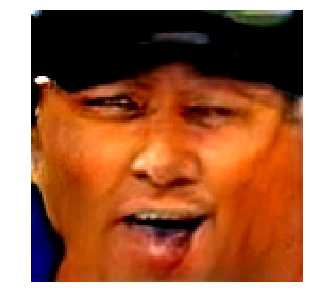

Tensor("Const_30:0", shape=(1, 512), dtype=float32)


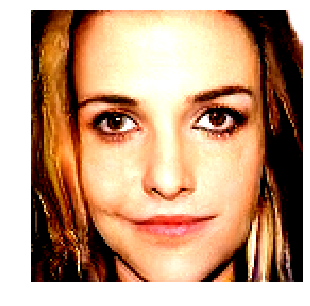

Tensor("Const_31:0", shape=(1, 512), dtype=float32)


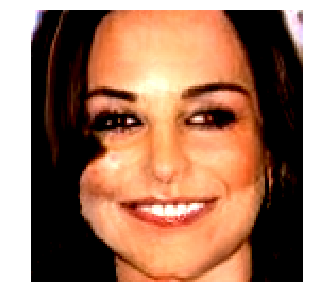

In [59]:
image_return1 = get_module_pd_image(img_arr_in(target_image1) - img_arr_in(target_image2))
display_image(image_return1)
image_return2 = get_module_pd_image(img_arr_in(target_image2) - img_arr_in(target_image1))
display_image(image_return2)
image_return3 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2))
display_image(image_return3)
image_return4 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1))
display_image(image_return4)
image_return5 = get_module_pd_image(img_arr_in(target_image1) - img_arr_in(target_image2[:,:,2]))
display_image(image_return5)
image_return6 = get_module_pd_image(img_arr_in(target_image2) - img_arr_in(target_image1[:,:,2]))
display_image(image_return6)
image_return7 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2[:,:,2]))
display_image(image_return7)
image_return8 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1[:,:,2]))
display_image(image_return8)
image_return9 = get_module_pd_image(img_arr_in(target_image1[:,:,0]) - img_arr_in(target_image2[:,:,2]))
display_image(image_return9)
image_return10 = get_module_pd_image(img_arr_in(target_image2[:,:,0]) - img_arr_in(target_image1[:,:,2]))
display_image(image_return10)
image_return11 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2[:,:,0]))
display_image(image_return11)
image_return12 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1[:,:,0]))
display_image(image_return12)

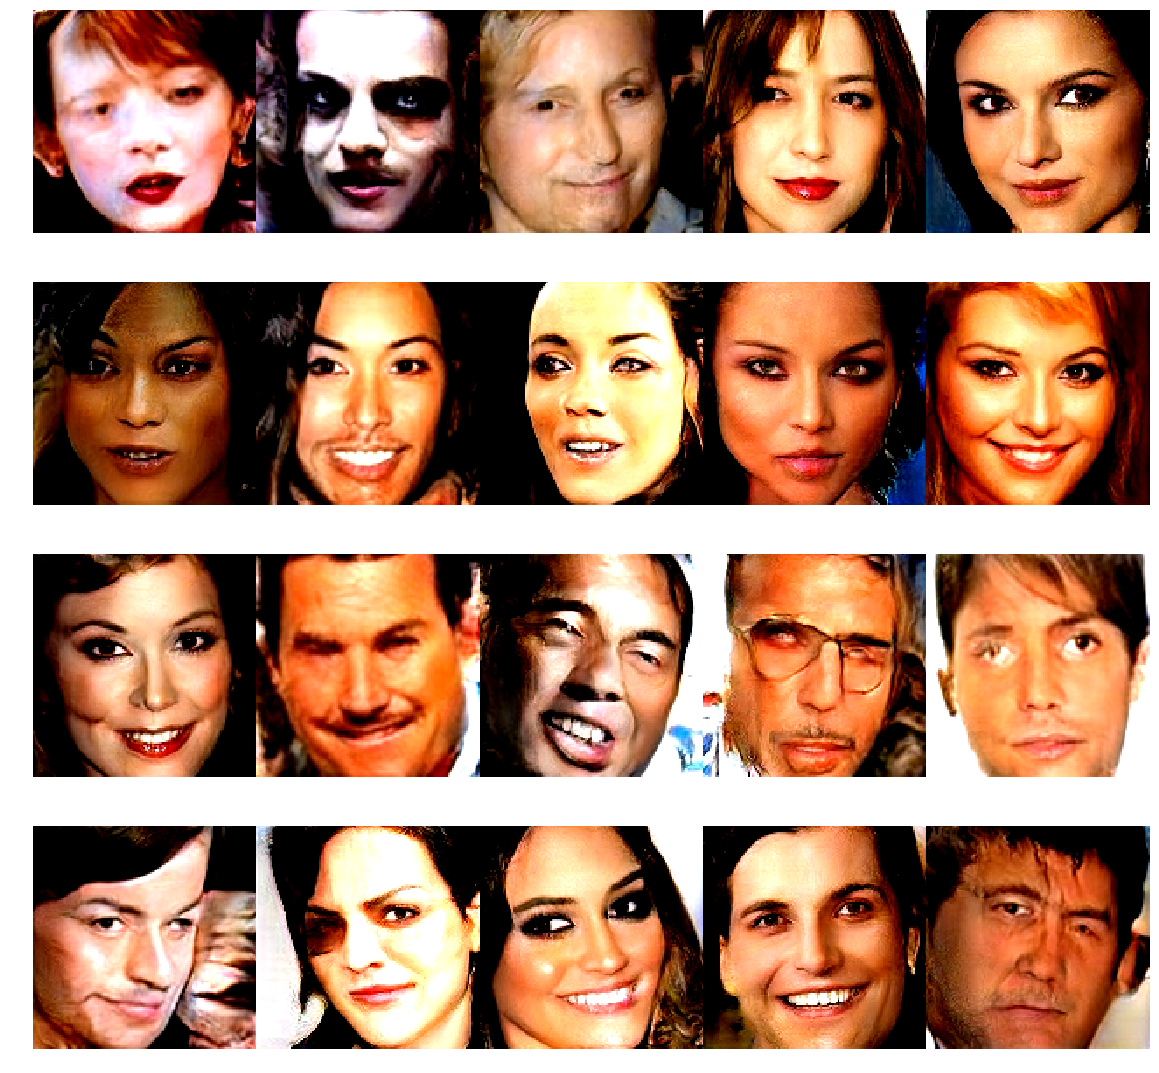

In [0]:
multi_images = get_multi_mod_images(20)
plot_images(multi_images, 5, 4)

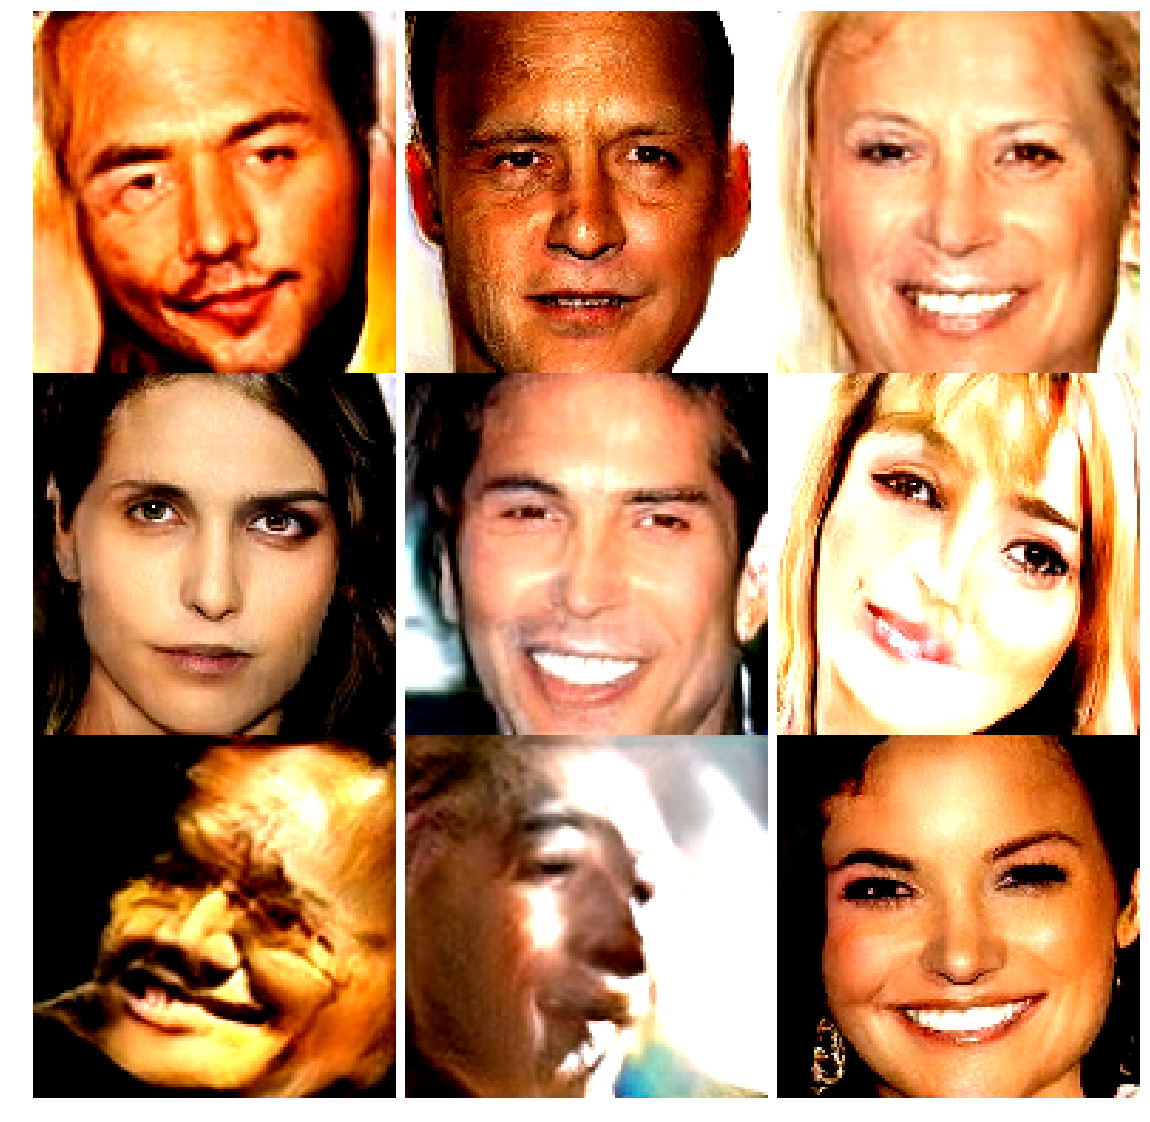

In [0]:
multi_images = get_rand_mod_images(9)
plot_images(multi_images, 3, 3)

After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values that minimize the loss.

In [0]:
result = find_closest_latent_vector(num_optimization_steps=40)
plot_images(result[0], [("Loss: %.2f" % loss) for loss in result[1]])

0.48175055
5.729374
5.1200123
2.750122
0.7604555
1.5990778
1.0211527
1.0037693
1.2597305
0.5420209
1.2311437
1.6266072
1.2416271
0.19856977
1.8218284
2.5356462
2.4496822
1.7160348
0.4751076
1.455363
2.2865405
2.4772515
2.1203132
1.2682606
0.43138438
1.0619988
1.0672878
0.5415735
0.7510832
1.081143
0.8936763
0.24577883
1.1328962
1.6093097
1.5410185
0.9971859
0.24010193
0.6129344
0.5020969
0.33854607


### Playing with the above example
If image is from the module space, the descent is quick and converges to a reasonable sample. Try out descending to an image that is **not from the module space**. The descent will only converge if the image is reasonably close to the space of training images.

How to make it descend faster and to a more realistic image? One can try:
* using different loss on the image difference, e.g. quadratic,
* using different regularizer on the latent vector,
* initializing from a random vector in multiple runs,
* etc.


In [0]:
module_spec = hub.load_module_spec("https://tfhub.dev/google/progan-128/1")
help(module_spec)

Help on _ModuleSpec in module tensorflow_hub.native_module object:

class _ModuleSpec(tensorflow_hub.module_spec.ModuleSpec)
 |  ModuleSpec for Hub's native Module format (backed by SavedModel).
 |  
 |  Method resolution order:
 |      _ModuleSpec
 |      tensorflow_hub.module_spec.ModuleSpec
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, saved_model_handler, checkpoint_variables_path)
 |      Private constructor.
 |      
 |      Args:
 |        saved_model_handler: SavedModelHandler backing up this Module definition.
 |        checkpoint_variables_path: An optional string to the checkpoint where this
 |          Module variables are checkpointed. If given the variables initializers
 |          are overridden to load from it.
 |      
 |      Raises:
 |        ValueError: if SavedModel contains any unexpected value.
 |  
 |  get_input_info_dict(self, signature=None, tags=None)
 |      Describes the inputs required by a signature.
 |      
 |      Args:

In [0]:
# Helper functions for TF Graph visualization
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [0]:
show_graph(graph)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [0]:
#graph = graph.as_default()
with graph.as_default():
  layers = [op.values() for op in graph.get_operations() if 'input' in op.name]
  print((layers))

print('Number of layers', len(layers))